In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, f1_score, ConfusionMatrixDisplay, make_scorer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import TomekLinks
import seaborn as sns
from scipy.stats import randint
from xgboost import XGBClassifier


df = pd.read_csv(r"C:\Users\Erensu Akdogan\Downloads\New folder\application_record.csv")
cr= pd.read_csv(r"C:\Users\Erensu Akdogan\Downloads\New folder\credit_record.csv")

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [83]:
df['ID'].nunique()


438510

In [32]:
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


<h1> DATA CLEANING

In [33]:
df = df.drop_duplicates()
df = df.drop_duplicates(subset=['ID']) # ID should be unique. For some reason there are duplicated IDs
df = df.drop(columns = 'CNT_CHILDREN') # this is redundant as we already have CNT_FAM_MEMBERS
df = df.drop(columns = 'OCCUPATION_TYPE') # this has missing values, better to get rid of.
df = df.drop(columns = 'FLAG_MOBIL') # this is 1 for all


In [34]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,2.0
1,5008805,M,Y,Y,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,2.0
2,5008806,M,Y,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,2.0
3,5008808,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,1.0
4,5008809,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,1.0


<h1>CREATING CUSTOMER LABELS & FEATURE ENGINEERING
    

In [35]:
cr['STATUS'].value_counts()

STATUS
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64


<h2> ORIGINAL MAPPING <h2>

0: 1-29 days past due

1: 30-59 days past due

2: 60-89 days overdue

3: 90-119 days overdue

4: 120-149 days overdue

5: Overdue or bad debts, write-offs for more than 150 days

C: paid off that month

X: No loan for the month


In [36]:
#Drop al the X's as the customers had no obligations to pay anything in this month. create a new DF.  
cr = cr[cr['STATUS'] != 'X']


In [37]:
cr['STATUS'].value_counts()

STATUS
C    442031
0    383120
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64

In [38]:
cr['STATUS'].replace('C',100, inplace =True)
cr['STATUS'] = cr['STATUS'].astype(int)
cr['STATUS'] = cr['STATUS'].apply(lambda x : x+1 )
cr['STATUS'] = cr['STATUS'].apply(lambda x: 0 if x == 101 else x)

In [39]:
cr['STATUS'].value_counts()

STATUS
0    442031
1    383120
2     11090
6      1693
3       868
4       320
5       223
Name: count, dtype: int64

In [40]:
#Create a new variable. "Months_on_Book". i.e. Duration of the loan. 
cr['Months_on_Book'] = cr.groupby('ID')['MONTHS_BALANCE'].transform('min')*-1

In [41]:
#Sum the Statuses (Can be thought as a total penalty point)

sc = cr.groupby('ID').agg({'STATUS': 'sum', 'Months_on_Book': 'first'}).reset_index()

# Create a Average_DPD metric

sc['Average_DPD'] = sc['STATUS'] / sc['Months_on_Book']

# its risky if average DPD is over 45 days i.e 1.5 .

sc['STATUS'] = sc['Average_DPD'].apply(lambda x: 1 if x >= 1.5 else 0)

sc['STATUS'].value_counts() # imbalanced 


STATUS
0    39583
1     1866
Name: count, dtype: int64

In [42]:
# Merge the two tables
mdf = pd.merge(sc, df, on='ID')

In [43]:
#We don't need Average_DPD anymore. Can't use as independent cause I use this to calculate the dependent variable. Possible data leakege. Also this is not known at the time of inception. 
mdf = mdf.drop(columns='Average_DPD')

In [44]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33110 entries, 0 to 33109
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   33110 non-null  int64  
 1   STATUS               33110 non-null  int64  
 2   Months_on_Book       33110 non-null  int64  
 3   CODE_GENDER          33110 non-null  object 
 4   FLAG_OWN_CAR         33110 non-null  object 
 5   FLAG_OWN_REALTY      33110 non-null  object 
 6   AMT_INCOME_TOTAL     33110 non-null  float64
 7   NAME_INCOME_TYPE     33110 non-null  object 
 8   NAME_EDUCATION_TYPE  33110 non-null  object 
 9   NAME_FAMILY_STATUS   33110 non-null  object 
 10  NAME_HOUSING_TYPE    33110 non-null  object 
 11  DAYS_BIRTH           33110 non-null  int64  
 12  DAYS_EMPLOYED        33110 non-null  int64  
 13  FLAG_WORK_PHONE      33110 non-null  int64  
 14  FLAG_PHONE           33110 non-null  int64  
 15  FLAG_EMAIL           33110 non-null 

In [45]:
# MAKE THEM NICE

mdf.rename(columns={
    'ID': 'Client_ID',
    'CODE_GENDER': 'Gender',
    'FLAG_OWN_CAR': 'Owns_Car',
    'FLAG_OWN_REALTY': 'Owns_Realty',
    'AMT_INCOME_TOTAL': 'Annual_Income',
    'NAME_INCOME_TYPE': 'Income_Type',
    'NAME_EDUCATION_TYPE': 'Education_Type',
    'NAME_FAMILY_STATUS': 'Family_Status',
    'NAME_HOUSING_TYPE': 'Housing_Type',
    'DAYS_BIRTH': 'Days_Since_Birth',
    'DAYS_EMPLOYED': 'Days_Employed',
    'FLAG_WORK_PHONE': 'Has_Work_Phone',
    'FLAG_PHONE': 'Has_Phone',
    'FLAG_EMAIL': 'Has_Email',
    'OCCUPATION_TYPE': 'Occupation',
    'CNT_FAM_MEMBERS': 'Family_Size',
    'MONTHS_BALANCE': 'Months_Since_Last_Installment',
    'STATUS': 'Loan_Status'
}, inplace=True)

In [46]:
mdf.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33110 entries, 0 to 33109
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Client_ID         33110 non-null  int64  
 1   Loan_Status       33110 non-null  int64  
 2   Months_on_Book    33110 non-null  int64  
 3   Gender            33110 non-null  object 
 4   Owns_Car          33110 non-null  object 
 5   Owns_Realty       33110 non-null  object 
 6   Annual_Income     33110 non-null  float64
 7   Income_Type       33110 non-null  object 
 8   Education_Type    33110 non-null  object 
 9   Family_Status     33110 non-null  object 
 10  Housing_Type      33110 non-null  object 
 11  Days_Since_Birth  33110 non-null  int64  
 12  Days_Employed     33110 non-null  int64  
 13  Has_Work_Phone    33110 non-null  int64  
 14  Has_Phone         33110 non-null  int64  
 15  Has_Email         33110 non-null  int64  
 16  Family_Size       33110 non-null  float6

<h1>PREPROCESSING 

In [47]:
# Y and N to 1 and 0
mdf['Owns_Car'] = mdf['Owns_Car'].apply(lambda x: 1 if x == 'Y' else 0)
mdf['Owns_Realty'] = mdf['Owns_Realty'].apply(lambda x: 1 if x == 'Y' else 0)


numerical = mdf.select_dtypes(include = 'number')
numerical.drop(columns=['Loan_Status', 'Client_ID'], inplace=True) # first is our dependent, We don't need no ID

categorical = mdf.select_dtypes(include = object)

ordinal = categorical[["Education_Type"]] # There is ordinality
enc = OrdinalEncoder(categories = [['Lower secondary', 'Incomplete higher', 'Secondary / secondary special', 'Higher education', 'Academic degree']])
ordinal['Education_Type']=enc.fit_transform(ordinal[['Education_Type']])

nominal = categorical.drop(columns= 'Education_Type')
nominal=pd.get_dummies(nominal, dtype=int)

#lets put them together
ndf=pd.concat([nominal, ordinal, numerical], axis = 1)


C:\Users\Erensu Akdogan\AppData\Local\Temp\ipykernel_3828\3739640854.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ordinal['Education_Type']=enc.fit_transform(ordinal[['Education_Type']])


In [48]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33110 entries, 0 to 33109
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Gender_F                            33110 non-null  int32  
 1   Gender_M                            33110 non-null  int32  
 2   Income_Type_Commercial associate    33110 non-null  int32  
 3   Income_Type_Pensioner               33110 non-null  int32  
 4   Income_Type_State servant           33110 non-null  int32  
 5   Income_Type_Student                 33110 non-null  int32  
 6   Income_Type_Working                 33110 non-null  int32  
 7   Family_Status_Civil marriage        33110 non-null  int32  
 8   Family_Status_Married               33110 non-null  int32  
 9   Family_Status_Separated             33110 non-null  int32  
 10  Family_Status_Single / not married  33110 non-null  int32  
 11  Family_Status_Widow                 33110

In [49]:
#Convert Dates

ndf['Age'] = (ndf['Days_Since_Birth'] / -365).round(3)
ndf['Months_Employed'] = (ndf['Days_Employed'] / -30).round(3)

#Drop the originals

ndf.drop(columns = ['Days_Since_Birth', 'Days_Employed'], inplace = True)


<Axes: >

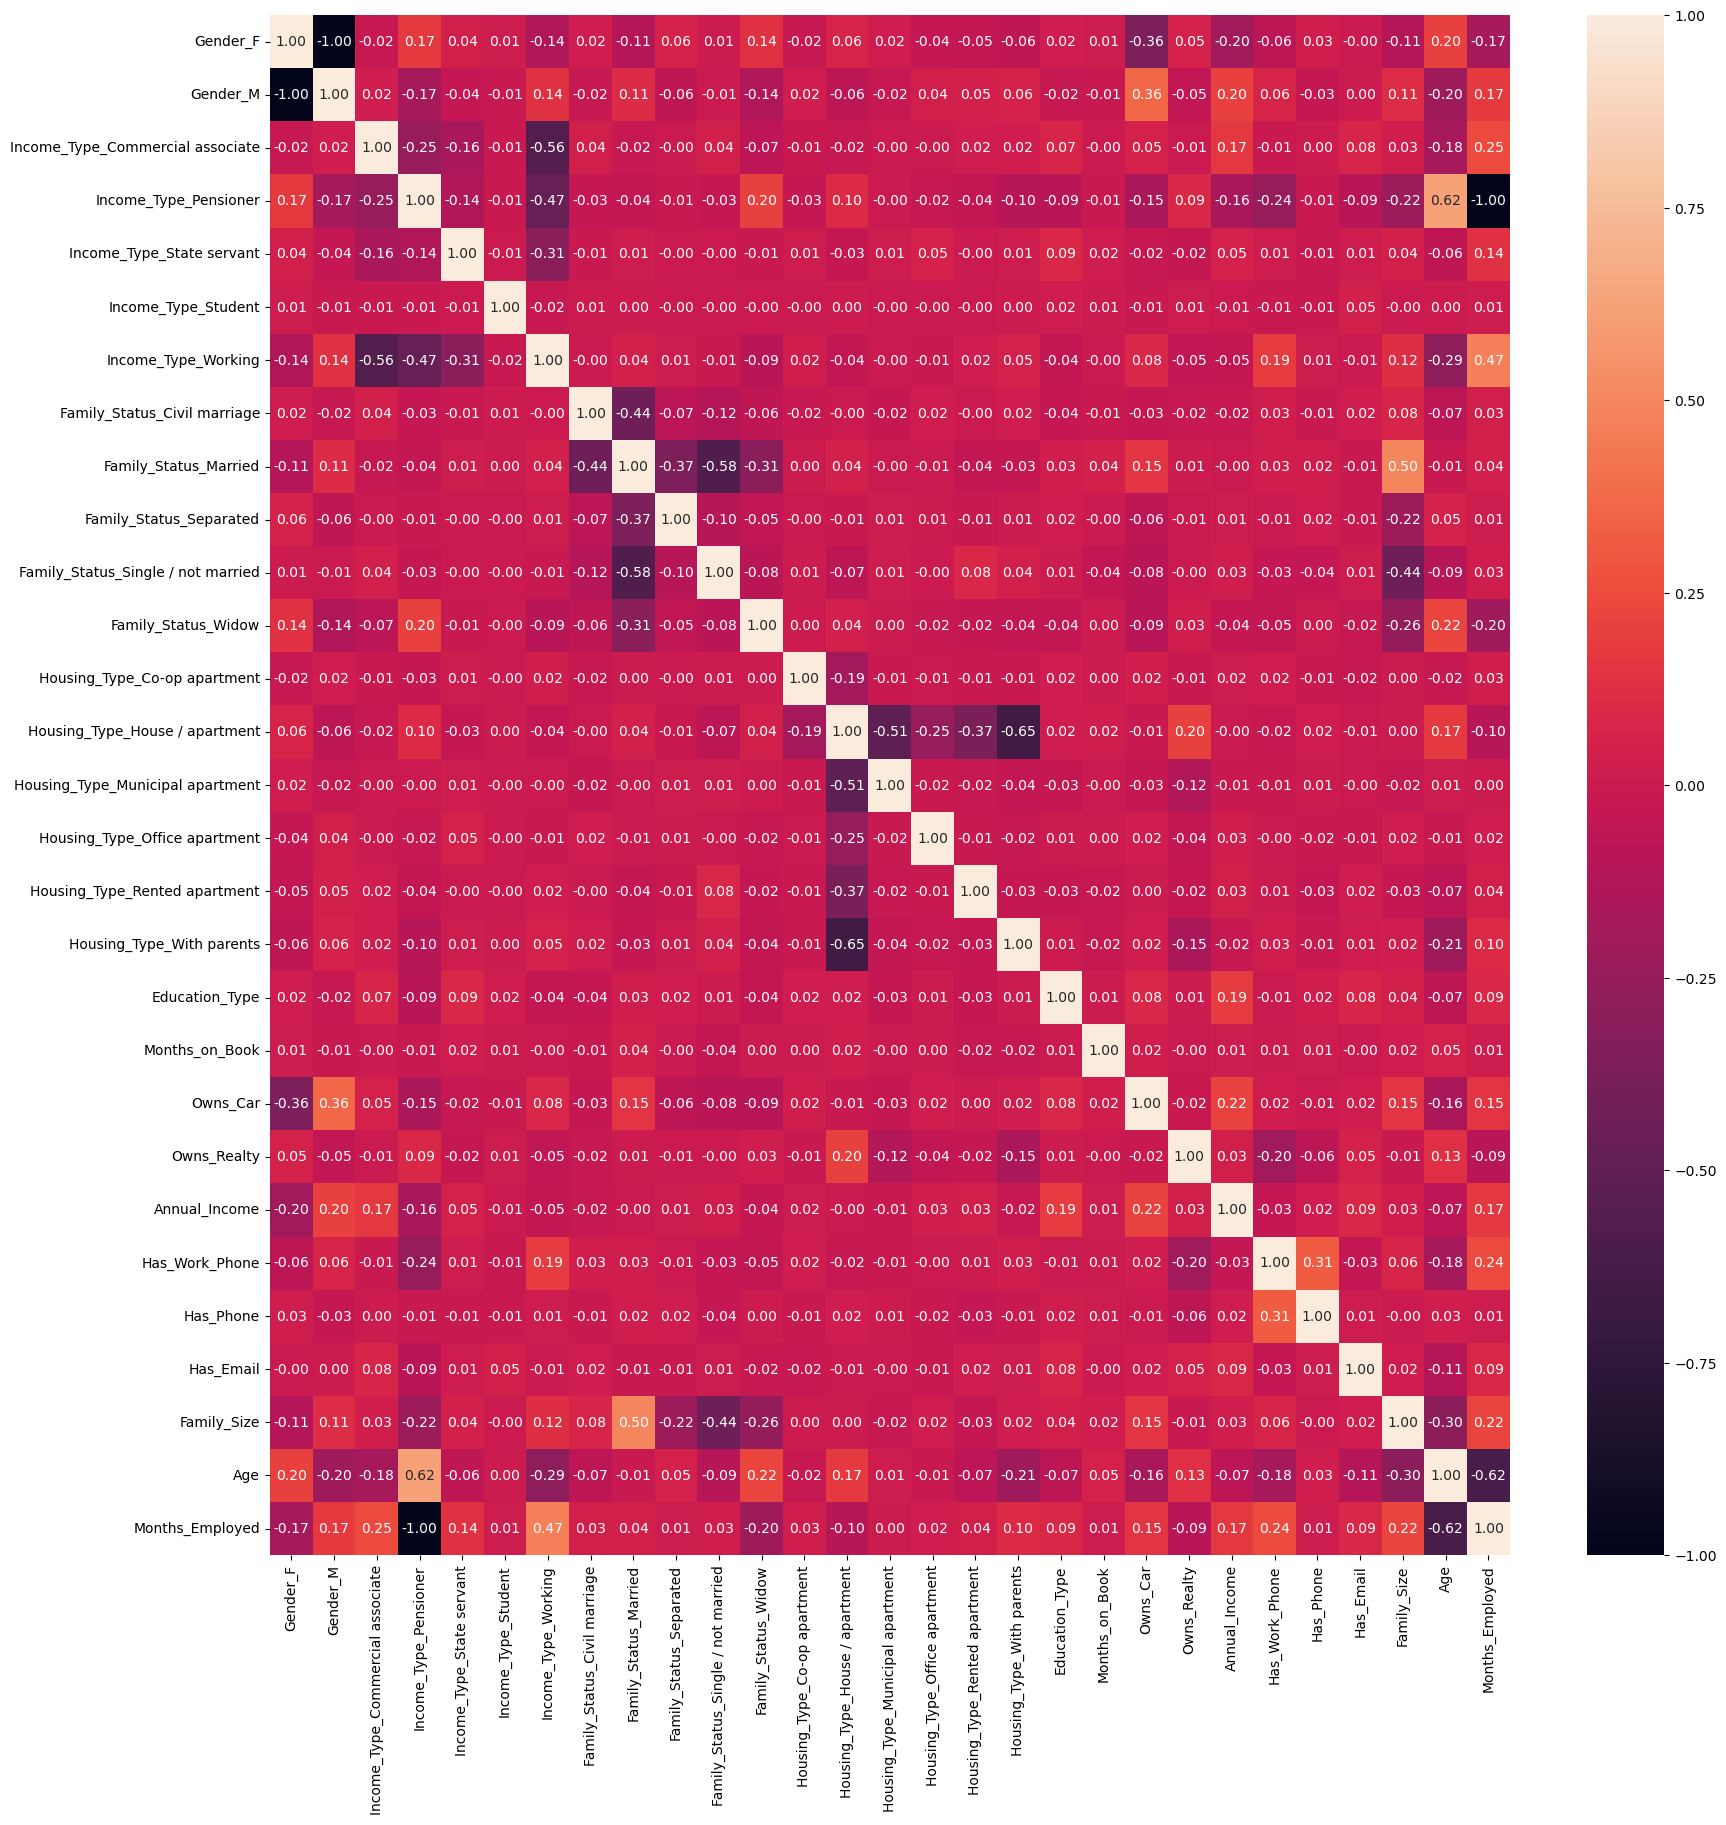

In [50]:
#CORRELATION HEATMAP
plt.figure(figsize=(20,20))
sns.heatmap(ndf.corr(),cmap='rocket',fmt='.2f',annot=True,vmin=-1,vmax=1)

<h1> X - Y SPLIT

In [89]:
X=ndf
y=mdf[['Loan_Status']]

<h1> TESTS - TRAIN SPLIT
    

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=11)


print('Train distibution: ', y_train.value_counts())
print('Test distibution: ', y_test.value_counts())

Train distibution:  Loan_Status
0              22037
1               1140
Name: count, dtype: int64
Test distibution:  Loan_Status
0              9456
1               477
Name: count, dtype: int64


In [91]:
# Create an instance of TomekLinks
tl = TomekLinks()

# Fit and resample the data
X_train, y_train = tl.fit_resample(X_train, y_train)

In [92]:
print('Train distibution: ', y_train.value_counts())

Train distibution:  Loan_Status
0              21714
1               1140
Name: count, dtype: int64


<h1> SCALE THE DATA

In [93]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) 
X_test= scaler.transform(X_test)

<h1> SMOTE

In [94]:
smote = SMOTE()

X_train, y_train = smote.fit_resample(X_train, y_train)
y_train.value_counts()

Loan_Status
0              21714
1              21714
Name: count, dtype: int64

In [95]:
#one last editing for regression
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [96]:
X.describe()

,Gender_F,Gender_M,Income_Type_Commercial associate,Income_Type_Pensioner,Income_Type_State servant,Income_Type_Student,Income_Type_Working,Family_Status_Civil marriage,Family_Status_Married,Family_Status_Separated,...,Months_on_Book,Owns_Car,Owns_Realty,Annual_Income,Has_Work_Phone,Has_Phone,Has_Email,Family_Size,Age,Months_Employed
count,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,...,33110.000000,33110.000000,33110.000000,3.311000e+04,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000
mean,0.671096,0.328904,0.230353,0.170915,0.082634,0.000332,0.515766,0.080217,0.686349,0.057626,...,25.429236,0.377288,0.673150,1.858772e+05,0.224011,0.292419,0.090396,2.194654,43.855517,-2001.034356
std,0.469822,0.469822,0.421065,0.376440,0.275332,0.018224,0.499759,0.271634,0.463984,0.233039,...,16.364444,0.484715,0.469069,1.014124e+05,0.416936,0.454881,0.286752,0.911076,11.543521,4611.506284
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.700000e+04,0.000000,0.000000,0.000000,1.000000,21.110000,-12174.767000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,11.000000,0.000000,0.000000,1.215000e+05,0.000000,0.000000,0.000000,2.000000,34.140000,13.500000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,24.000000,0.000000,1.000000,1.575000e+05,0.000000,0.000000,0.000000,2.000000,42.866000,51.733000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,38.000000,1.000000,1.000000,2.250000e+05,0.000000,1.000000,0.000000,3.000000,53.411000,105.299750
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,60.000000,1.000000,1.000000,1.575000e+06,1.000000,1.000000,1.000000,20.000000,68.910000,523.767000


<h1>LOGISTIC REGRESSION AS BENCHMARK

In [97]:

log_model = LogisticRegression() 

log_model.fit(X_train, y_train)

y_pred_train_log = log_model.predict(X_train)
y_pred_test_log = log_model.predict(X_test)

performance_log = pd.DataFrame({'Error_metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
                                'Train': [accuracy_score(y_train, y_pred_train_log),
                                          precision_score(y_train, y_pred_train_log),
                                          recall_score(y_train, y_pred_train_log),
                                          f1_score(y_train, y_pred_train_log),
                                          roc_auc_score(y_train, y_pred_train_log)],
                                'Test': [accuracy_score(y_test, y_pred_test_log),
                                         precision_score(y_test, y_pred_test_log),
                                         recall_score(y_test, y_pred_test_log),
                                         f1_score(y_test, y_pred_test_log),
                                         roc_auc_score(y_test, y_pred_test_log)]})

display(performance_log)

,Error_metric,Train,Test
0,Accuracy,0.853505,0.795228
1,Precision,0.815392,0.181073
2,Recall,0.913926,0.926625
3,F1 Score,0.861852,0.302947
4,ROC AUC,0.853505,0.857612


<h4> PARAM TUNING FOR LOGISTIC REG
    

In [59]:
# Define hyperparameters to search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Create logistic regression model
logistic = LogisticRegression(max_iter=1000)

# Create grid search object with F1 score as the scoring metric
grid_search = GridSearchCV(logistic, param_grid, scoring='f1', cv=5)

# Fit grid search to the data
grid_search.fit(X_train, y_train)

# Get best parameters and best F1 score
best_params_lr = grid_search.best_params_
best_f1_score = grid_search.best_score_

print(best_params_lr)

C:\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


Penalty: In the context of machine learning models like logistic regression, penalty refers to a term added to the model's cost function. This term penalizes the model for being too complex by adding a cost for large coefficient values. There are typically two types of penalties used: L1 and L2.

L1 Penalty (Lasso): It adds the sum of the absolute values of the coefficients to the cost function. This penalty encourages sparsity in the model, meaning it tends to push some of the coefficients to exactly zero, effectively performing feature selection by eliminating less important features.

L2 Penalty (Ridge): It adds the sum of the squared values of the coefficients to the cost function. This penalty discourages large coefficient values and promotes smoother and more stable models. It doesn't force coefficients to be exactly zero like L1 penalty does, but it still reduces the impact of less important features.

C: C is the regularization parameter in logistic regression models. It controls the strength of the regularization penalty applied to the coefficients. A smaller value of C indicates stronger regularization, meaning the model is penalized more for complex models. Conversely, a larger value of C reduces the strength of regularization, allowing the model to fit the training data more closely.

Solver: The solver is the algorithm used to optimize the logistic regression model's cost function and find the best coefficients. Different solvers use different optimization techniques, and their choice can affect the model's performance, especially when dealing with large datasets or highly imbalanced classes.

'liblinear': This solver is suitable for small datasets and is based on a coordinate descent algorithm. It performs well for binary classification tasks.

'saga': This solver is an extension of the stochastic average gradient descent algorithm. It's often preferred for large datasets and supports both L1 and L2 penalties. It's particularly useful when dealing with large-scale problems and when faster convergence is desired

<h3> Logistic Regression MODEL optimized

In [60]:
# Create the Logistic Regression model with best parameters found above
log_model = LogisticRegression(**best_params_lr)

# Fit the model to the training data
log_model.fit(X_train, y_train)

y_prob_train = log_model.predict_proba(X_train)[:, 1]
y_prob_test = log_model.predict_proba(X_test)[:, 1]

# Set threshold
threshold = 0.8

# Make predictions based on the adjusted threshold
y_pred_train_log_high_threshold = (y_prob_train >= threshold).astype(int)
y_pred_test_log_high_threshold = (y_prob_test >= threshold).astype(int)

# Calculate performance metrics
performance_log_reg_optimized = pd.DataFrame({
    'Error_metric': ['Accuracy', 'Precision', 'Recall', 'ROC AUC', 'F1 Score'],
    'Train': [accuracy_score(y_train, y_pred_train_log_high_threshold),
              precision_score(y_train, y_pred_train_log_high_threshold),
              recall_score(y_train, y_pred_train_log_high_threshold),
              roc_auc_score(y_train, y_prob_train),
              f1_score(y_train, y_pred_train_log_high_threshold)],
    'Test': [accuracy_score(y_test, y_pred_test_log_high_threshold),
             precision_score(y_test, y_pred_test_log_high_threshold),
             recall_score(y_test, y_pred_test_log_high_threshold),
             roc_auc_score(y_test, y_prob_test),
             f1_score(y_test, y_pred_test_log_high_threshold)]
})

# Display performance metrics
display(performance_log_reg_optimized)


,Error_metric,Train,Test
0,Accuracy,0.873474,0.958321
1,Precision,0.961464,0.524444
2,Recall,0.778136,0.791946
3,ROC AUC,0.945010,0.937644
4,F1 Score,0.860140,0.631016


<H3>Optimize the Threshold


In [61]:
#Optimized the Threshold
from sklearn.metrics import f1_score

threshold_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

best_threshold = None
best_f1_score = 0

for threshold in threshold_values:
    # Make predictions based on the adjusted threshold
    y_pred_train_threshold = (y_prob_train >= threshold).astype(int)
    y_pred_test_threshold = (y_prob_test >= threshold).astype(int)
    
    # Calculate F1 score on the test set
    f1 = f1_score(y_test, y_pred_test_threshold)
    
    # Check if the current threshold gives a higher F1 score
    if f1 > best_f1_score:
        best_threshold = threshold
        best_f1_score = f1

print("Best threshold:", best_threshold)
print("Best F1 score:", best_f1_score)


Best threshold: 0.8
Best F1 score: 0.6310160427807486


<h1> DECISION TREE

<h4> PARAM TUNING

In [71]:
RAND_STATE = 42

# Define the parameter grid for Decision Tree
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],  
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_leaf_nodes': [None] + list(range(2, 20, 2))
}

clf = DecisionTreeClassifier(random_state=RAND_STATE)

f1_scorer = make_scorer(f1_score)

# Initialize RandomizedSearchCV with f1_score as the scoring metric
random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=100, cv=5, 
                                   scoring=f1_scorer, random_state=RAND_STATE, 
                                   return_train_score=True, n_jobs=-1)

# Fit the random search to the training data
random_search.fit(X_train, y_train)


# Get the best parameters
best_params_dt = random_search.best_params_

print("Best Parameters:", best_params_dt)


Best Parameters: {'splitter': 'random', 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': None, 'criterion': 'gini'}


In [72]:
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': [None, 0.5],  # Specify a fraction of total features
    'criterion': ['gini', 'entropy'],
    'splitter': ['best'],
    'max_leaf_nodes': [None] + list(range(2, 10, 2))
}

clf = DecisionTreeClassifier(random_state=RAND_STATE)

random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=50, cv=5, 
                                   scoring=f1_scorer, random_state=RAND_STATE, 
                                   return_train_score=True, n_jobs=-1)

random_search.fit(X_train, y_train)

best_params_dt = random_search.best_params_
print("Best Parameters:", best_params_dt)


Best Parameters: {'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 7, 'criterion': 'entropy'}


<h3> Decision Tree Model

In [73]:
# Create a DecisionTreeClassifier instance with the best parameters
model = DecisionTreeClassifier(**best_params_dt)

# Fit the model to your training data
model.fit(X_train, y_train)

y_pred_train_dt = model.predict(X_train)
y_pred_test_dt = model.predict(X_test)

# Calculate accuracy, precision, and recall for the training set
accuracy_train = accuracy_score(y_train, y_pred_train_dt)
precision_train = precision_score(y_train, y_pred_train_dt)
recall_train = recall_score(y_train, y_pred_train_dt)

# Calculate accuracy, precision, and recall for the test set
accuracy_test = accuracy_score(y_test, y_pred_test_dt)
precision_test = precision_score(y_test, y_pred_test_dt)
recall_test = recall_score(y_test, y_pred_test_dt)

# Calculate F1 score and ROC AUC score for the training set
f1_train = f1_score(y_train, y_pred_train_dt)
roc_auc_train = roc_auc_score(y_train, y_pred_train_dt)

# Calculate F1 score and ROC AUC score for the test set
f1_test = f1_score(y_test, y_pred_test_dt)
roc_auc_test = roc_auc_score(y_test, y_pred_test_dt)

# Create a DataFrame to store performance metrics
performance_dt = pd.DataFrame({
    'Error_metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'Train': [accuracy_train, precision_train, recall_train, f1_train, roc_auc_train],
    'Test': [accuracy_test, precision_test, recall_test, f1_test, roc_auc_test]
})

# Display the performance DataFrame
display(performance_dt)


,Error_metric,Train,Test
0,Accuracy,0.930914,0.959680
1,Precision,0.966295,0.533769
2,Recall,0.892977,0.822148
3,F1 Score,0.928190,0.647292
4,ROC AUC,0.930914,0.894154


<h1> KNN 

<h3>PARAM TUNING


In [64]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distributions for RandomizedSearchCV
param_dist = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
    'p': [1, 2]
}

# Instantiate the KNN classifier
knn = KNeighborsClassifier()

# Initialize RandomizedSearchCV with F1 score as the scoring metric
random_search = RandomizedSearchCV(knn, param_distributions=param_dist, 
                                   n_iter=100, scoring=make_scorer(f1_score), cv=5)

# Fit random search to the training data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params_knn = random_search.best_params_

print("Best Parameters:", best_params_knn)


Best Parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 3, 'leaf_size': 30, 'algorithm': 'ball_tree'}


<h3> KNN MODEL

In [65]:
# Instantiate the KNN classifier with the best parameters
best_knn = KNeighborsClassifier(**best_params_knn)

# Fit the model to the training data
best_knn.fit(X_train, y_train)

# Predictions
y_pred_train = best_knn.predict(X_train)
y_pred_test = best_knn.predict(X_test)

# Calculate accuracy, precision, recall, F1 score, and ROC AUC for training set
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)
roc_auc_train = roc_auc_score(y_train, y_pred_train)

# Calculate accuracy, precision, recall, F1 score, and ROC AUC for test set
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_pred_test)

# Display the performance metrics
performance_knn = pd.DataFrame({
    'Error_metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'Train': [accuracy_train, precision_train, recall_train, f1_train, roc_auc_train],
    'Test': [accuracy_test, precision_test, recall_test, f1_test, roc_auc_test]
})

display(performance_knn)


,Error_metric,Train,Test
0,Accuracy,0.999154,0.926004
1,Precision,1.000000,0.280822
2,Recall,0.998308,0.412752
3,F1 Score,0.999153,0.334239
4,ROC AUC,0.999154,0.681471


<h1>XGBoost

<h3> PARAM TUNING

In [66]:
# Define the parameter grid for XGBoost
param_dist = {
    'max_depth': randint(1, 20),
    'n_estimators': randint(50, 500),
    'learning_rate': [0.01, 0.1, 0.2]
}

random_search = RandomizedSearchCV(estimator=XGBClassifier(), param_distributions=param_dist, 
                                   n_iter=100, cv=5, scoring='f1', random_state=42)
random_search.fit(X_train, y_train)

# Obtain the best parameters
best_params_XG = random_search.best_params_
print("Best parameters found: ", best_params_XG)


Best parameters found:  {'learning_rate': 0.2, 'max_depth': 13, 'n_estimators': 282}


<h3> PARAM TUNING w.Regulazation


<h3> XG Booster Model
    

In [67]:
# Create XGBClassifier with best parameters
model = XGBClassifier(**best_params_XG, min_child_weight=8, subsample=0.8, seed=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Calculate evaluation metrics
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)
roc_auc_train = roc_auc_score(y_train, y_pred_train)

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_pred_test)

# Create a DataFrame
performance_xg= pd.DataFrame({
    'Error_metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'Train': [accuracy_train, precision_train, recall_train, f1_train, roc_auc_train],
    'Test': [accuracy_test, precision_test, recall_test, f1_test, roc_auc_test]
})
# Display the DataFrame
print(performance_xg)


  Error_metric     Train      Test
0     Accuracy  0.997764  0.976140
1    Precision  0.998025  0.718750
2       Recall  0.997502  0.771812
3     F1 Score  0.997763  0.744337
4      ROC AUC  0.997764  0.878790


<h4> XGB with regulazation

In [75]:
# Create XGBClassifier without specifying parameters
model = XGBClassifier(seed=42)

# Define parameter grid for RandomizedSearchCV
param_dist = {
    'max_depth': randint(3, 10),
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': randint(50, 500),
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1],
    'reg_lambda': [0, 0.001, 0.01, 0.1, 1],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 3, 5, 7, 10],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Initialize RandomizedSearchCV with f1_score as the scoring metric
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=100, cv=5, 
                                   scoring='f1', random_state=42, n_jobs=-1)

# Fit the random search to the training data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params_xgboost = random_search.best_params_

# Create XGBClassifier with best parameters
best_model = XGBClassifier(**best_params_xgboost, seed=42)

# Fit the best model to the training data
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

# Calculate evaluation metrics
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)
roc_auc_train = roc_auc_score(y_train, y_pred_train)

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_pred_test)

# Create a DataFrame to display performance metrics
performance_xgboost = pd.DataFrame({
    'Error_metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'Train': [accuracy_train, precision_train, recall_train, f1_train, roc_auc_train],
    'Test': [accuracy_test, precision_test, recall_test, f1_test, roc_auc_test]
})

# Display the DataFrame
print(performance_xgboost)


  Error_metric     Train      Test
0     Accuracy  0.994802  0.977348
1    Precision  0.995921  0.734177
2       Recall  0.993674  0.778523
3     F1 Score  0.994796  0.755700
4      ROC AUC  0.994802  0.882620


Precision: Precision measures the accuracy of the positive predictions.The precision on the test data is low , indicating that among the instances predicted as defaults, only about x% actually default. This suggests that there might be a relatively high number of false positive predictions in your model.

Recall: Recall measures the proportion of actual positives that were correctly identified by the model. The recall on the test data is also low indicating that the model is not capturing many of the true defaults in the data.

These results suggest that model is good at predicting non-defaults due to its high accuracy, it struggles with correctly identifying defaults. 

You might want to focus on improving the precision and recall, perhaps by adjusting the classification threshold or exploring other algorithms that might handle imbalanced classes better, such as random forests or gradient boosting. Additionally, consider using techniques like oversampling or undersampling to address the class imbalance issue.





<h1> RANDOM FOREST

<H3> PARAM TUNING
    

In [68]:
# # Define the parameter grid to search
RAND_STATE = 42
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=RAND_STATE),
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           scoring='f1',
                           n_jobs=-1)  # Use all available CPU cores

# Perform grid search
grid_search.fit(X_train, y_train)

best_params_rf = grid_search.best_params_

# Print the best parameters found
print("Best parameters:", best_params_rf)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
accuracy = best_model.score(X_test, y_test)
print("Test accuracy:", accuracy)


C:\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
135 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Anaconda\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Anaconda\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_param

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}
Test accuracy: 0.9773482331621867


In [69]:

clf = RandomForestClassifier(**best_params_rf)

        #max_depth=6,min_samples_leaf=20,max_features=None,n_estimators=100,
         #                    bootstrap=True,oob_score=True, random_state=RAND_STATE)
clf.fit(X_train, y_train) # fit the training data 

# Make predictions on the test set
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

# Calculate accuracy, precision, recall, F1 score, and ROC AUC for test set
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_pred_test)

# Calculate accuracy, precision, recall, F1 score, and ROC AUC for training set
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)
roc_auc_train = roc_auc_score(y_train, y_pred_train)

# Display the performance metrics
performance_rf = pd.DataFrame({
    'Error_metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'Train': [accuracy_train, precision_train, recall_train, f1_train, roc_auc_train],
    'Test': [accuracy_test, precision_test, recall_test, f1_test, roc_auc_test]
})

display(performance_rf)



,Error_metric,Train,Test
0,Accuracy,0.999295,0.977801
1,Precision,0.999114,0.730887
2,Recall,0.999476,0.802013
3,F1 Score,0.999295,0.764800
4,ROC AUC,0.999295,0.894049


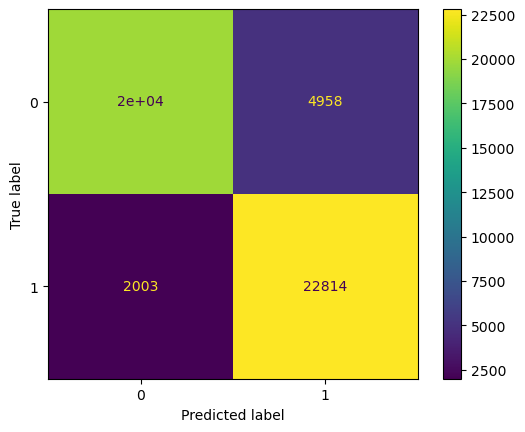

In [70]:
#Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_train = confusion_matrix(y_train, y_pred_train_log, labels = log_model.classes_)
disp = ConfusionMatrixDisplay(cm_train)
disp.plot()

In [47]:
#CROSS VALIDATION

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [51]:
model1 = DecisionTreeClassifier()
model2 = LogisticRegression()
model3 = KNeighborsClassifier()
model4 = RandomForestClassifier()
model5= XGBClassifier()


model_pipeline = [model1, model2, model3, model4, model5]
model_names = ['Classification Tree', 'Logistic Regression', 'KNN', 'RF', 'XG']
scores = {}
i=0
for model in model_pipeline:
    mean_score = np.mean(cross_val_score(model, X_test, y_test, cv=5, scoring = 'f1'))
    scores[model_names[i]] = mean_score
    i = i+1
print(scores)

{'Classification Tree': 0.5934771015289224, 'Logistic Regression': 0.1965112170994524, 'KNN': 0.012123995407577498, 'RF': 0.7175993446127871, 'XG': 0.7167780054926551}


,Error_metric,Train,Test
0,Accuracy,0.999256,0.975084
1,Precision,0.999115,0.729730
2,Recall,0.999397,0.768987
3,F1 Score,0.999256,0.748844
4,ROC AUC,0.999256,0.877266


  Error_metric     Train      Test
0     Accuracy  0.996039  0.975543
1    Precision  0.996138  0.745283
2       Recall  0.995938  0.750000
3     F1 Score  0.996038  0.747634
4      ROC AUC  0.996039  0.868495
